# Twitter Stance Detection  
W266 - NLP  
Alex Dessouky & Tim Spittle

NOTES to myself:
* why is classification report not outputting the micro, macro, weighted avgs?
* we have a class weighting problem
* getting different f1 scores if I call f1 directly vs classification report  
* summary by topic needed to more succinctly show this

## 1 - Load Packages & Data

In [37]:
# Data objects
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, hstack
from collections import Counter

# Text Manipulation
import re
import string

# Timing
import time

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer

# Models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn import metrics #f1_score, classification_report, confusion_matrix, roc_auc_score

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
# !pip install --upgrade tensorflow
# !pip install --upgrade tensorflow-hub

# Tensor Flow
import tensorflow as tf
import tensorflow_hub as hub

In [5]:
# elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

In [8]:
#load training data
twitter_train = pd.read_excel('./StanceDataset/train.xlsx')
twitter_train.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos


In [7]:
#load test data
twitter_test = pd.read_excel('./StanceDataset/test.xlsx')
twitter_test.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,He who exalts himself shall be humbled; a...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
1,RT @prayerbullets: I remove Nehushtan -previou...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,other
2,@Brainman365 @heidtjj @BenjaminLives I have so...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
3,#God is utterly powerless without Human interv...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@David_Cameron Miracles of #Multiculturalism...,Atheism,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


## 2 - Pre-process Data

In [15]:
def preprocess_tweets(x):
    
    # Remove punctuation EXCEPT for hashtags (#) and handles (@)
    exclude_punc = [punc for punc in string.punctuation if punc not in ['#', '@']]
    x_nopunc = ''.join(ch for ch in x if ch not in exclude_punc)

    # lower case
    x_lower = x_nopunc.lower()
    
    # Replace digits with DIGIT
    x_digits = re.sub("\d+", "DIGIT", x_lower)
    
    return x_digits

# Example tweet
print("Raw: " + str(twitter_train['Tweet'][0]))
print("Clean: " + str(preprocess_tweets(twitter_train['Tweet'][0])))

Raw: @tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot
Clean: @tedcruz and #handovertheserver she wiped clean  DIGITk deleted emails explains dereliction of dutylies re #benghazietc #tcot


In [16]:
# Labels
twitter_train['stance_label'] = np.array(twitter_train['Stance'].apply(lambda x: 
                                                                       2 if x == "FAVOR" else 
                                                                       (1 if x == "NONE" else 0)))
# Clean tweests
twitter_train['tweet_clean'] = np.array(twitter_train['Tweet'].apply(lambda x: preprocess_tweets(x)))

twitter_train.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment,stance_label,tweet_clean
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,0,@tedcruz and #handovertheserver she wiped clea...
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos,2,hillary is our best choice if we truly want to...
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,0,@theview i think our country is ready for a fe...
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,0,i just gave an unhealthy amount of my hardearn...
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos,1,@portiaaboulger thank you for adding me to you...


In [17]:
# Labels
twitter_test['stance_label'] = np.array(twitter_test['Stance'].apply(lambda x: 
                                                                     2 if x == "FAVOR" else 
                                                                     (1 if x == "NONE" else 0)))
# Clean tweests
twitter_test['tweet_clean'] = np.array(twitter_test['Tweet'].apply(lambda x: preprocess_tweets(x)))

twitter_test.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment,stance_label,tweet_clean
0,He who exalts himself shall be humbled; a...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos,0,he who exalts himself shall be humbled an...
1,RT @prayerbullets: I remove Nehushtan -previou...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,other,0,rt @prayerbullets i remove nehushtan previous ...
2,@Brainman365 @heidtjj @BenjaminLives I have so...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos,0,@brainmanDIGIT @heidtjj @benjaminlives i have ...
3,#God is utterly powerless without Human interv...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,0,#god is utterly powerless without human interv...
4,@David_Cameron Miracles of #Multiculturalism...,Atheism,AGAINST,2. The tweet does NOT expresses opinion about ...,neg,0,@davidcameron miracles of #multiculturalism ...


## 3 - Models

### Prep Output Functions

In [12]:
def confusion_plot(confusion_matrix, target_names):
    # Plot confusion matrix (via imshow)
    plt.imshow(confusion_matrix, interpolation = "nearest", cmap = plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    # Loop through each value of the matrix to add data labels
    width, height = confusion_matrix.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(confusion_matrix[x][y]), xy = (y, x), 
                        horizontalalignment = "center",
                        verticalalignment = "center")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
# Histograms of predicted probabilities
def class_prob_breakdown(model_results):
    plt.figure(figsize=(20, 10))

    plt.subplot(2,3,1)
    plt.title("Prob. Dist. - Predicted Against")
    plt.hist([item[0] for item in model_results['test_predict_proba']])

    plt.subplot(2,3,2)
    plt.title("Prob. Dist. - Predicted None")
    plt.hist([item[1] for item in model_results['test_predict_proba']])

    plt.subplot(2,3,3)
    plt.title("Prob. Dist. - Predicted Favor")
    plt.hist([item[2] for item in model_results['test_predict_proba']])

    plt.subplot(2,3,4)
    plt.title("Prob. Dist. - Probability Against, by True Label")
    sns.distplot([item[0] for item in model_results['test_predict_proba'][model_results['test_true_labels']==0]], 
                 hist = False, label = "True Against")
    sns.distplot([item[0] for item in model_results['test_predict_proba'][model_results['test_true_labels']==1]], 
                 hist = False, label = "True None")
    sns.distplot([item[0] for item in model_results['test_predict_proba'][model_results['test_true_labels']==2]], 
                 hist = False, label = "True Favor")

    plt.subplot(2,3,5)
    plt.title("Prob. Dist. - Probability None, by True Label")
    sns.distplot([item[1] for item in model_results['test_predict_proba'][model_results['test_true_labels']==0]], 
                 hist = False, label = "True Against")
    sns.distplot([item[1] for item in model_results['test_predict_proba'][model_results['test_true_labels']==1]], 
                 hist = False, label = "True None")
    sns.distplot([item[1] for item in model_results['test_predict_proba'][model_results['test_true_labels']==2]], 
                 hist = False, label = "True Favor")
    
    plt.subplot(2,3,6)
    plt.title("Prob. Dist. - Probability Against, by True Label")
    sns.distplot([item[2] for item in model_results['test_predict_proba'][model_results['test_true_labels']==0]], 
                 hist = False, label = "True Against")
    sns.distplot([item[2] for item in model_results['test_predict_proba'][model_results['test_true_labels']==1]], 
                 hist = False, label = "True None")
    sns.distplot([item[2] for item in model_results['test_predict_proba'][model_results['test_true_labels']==2]], 
                 hist = False, label = "True Favor")

    plt.show()
    
def standard_output(model_results):
    # Class Weights
    plt.subplot(1,2,1)
    model_results['train_names'].value_counts().plot(kind='bar', title = "Class Distribution - Train")
    plt.subplot(1,2,2)
    model_results['test_true_names'].value_counts().plot(kind='bar', title = "Class Distribution - Test")
    # Classification Report
    print(metrics.classification_report(y_true = model_results['test_true_labels'], 
                                        y_pred = model_results['test_predict'],
                                        target_names = ['Against', 'None', 'Favor']))
    # Confusion Matrix
    plt.figure(figsize=(15, 5))
    plt.subplot(1,2,1)
    confusion_plot(confusion_matrix = metrics.confusion_matrix(y_true = model_results['test_true_labels'], 
                                                               y_pred = model_results['test_predict']), 
                   target_names = ['Against', 'None', 'Favor'])
    # Class probability breakdown
    class_prob_breakdown(model_results = model_results)

### Baseline (ZeroR)

In [22]:
def baseline_stance(train, test, topic_in):
    # Subset data to topic being tested
    train_topic = train[train['Target'] == topic_in]
    test_topic = test[test['Target'] == topic_in]
    
    #### MODEL ####
    print(topic_in)
    # Majority Class
    majority_class = Counter(train_topic['stance_label']).most_common(1)[0][0]
    
    # Prediction
    # Repeat majority class n times
    test_predict = [majority_class] * len(test_topic['stance_label'])
    # Tuple of 3 index the majority class = 1
    majority_probs = [1 if i == majority_class else 0 for i in range(3)]
    test_predict_proba = []
    for i in range(len(test_topic['stance_label'])):
        test_predict_proba.append(majority_probs)
    
    # Results
    results_dict = {}
    results_dict['model'] = "None"
    results_dict['full_feature_list'] = "None"
    results_dict['train_labels'] = train_topic['stance_label']
    results_dict['train_names'] = train_topic['Stance']
    results_dict['test_true_labels'] = test_topic['stance_label']
    results_dict['test_true_names'] = test_topic['Stance']
    results_dict['test_predict'] = test_predict
    results_dict['test_predict_proba'] = np.array(test_predict_proba)
    
    return results_dict

Atheism
F1 Score: 0.6124401913875599
             precision    recall  f1-score   support

    Against       0.73      1.00      0.84       160
       None       0.00      0.00      0.00        28
      Favor       0.00      0.00      0.00        32

avg / total       0.53      0.73      0.61       220



/home/timspittle/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/timspittle/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/timspittle/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/timspittle/anaconda3/lib/python3.7/site-packages/statsmodels/

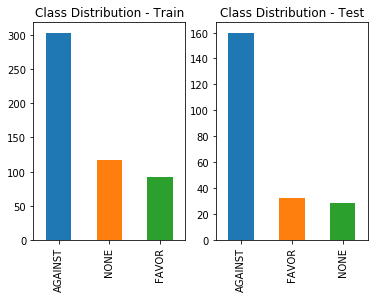

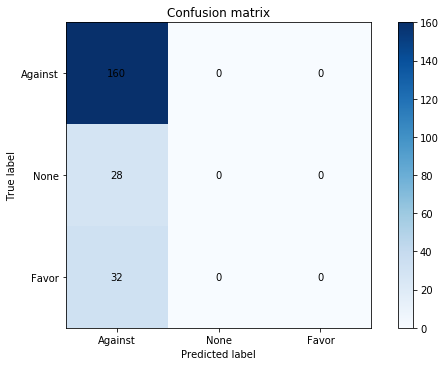

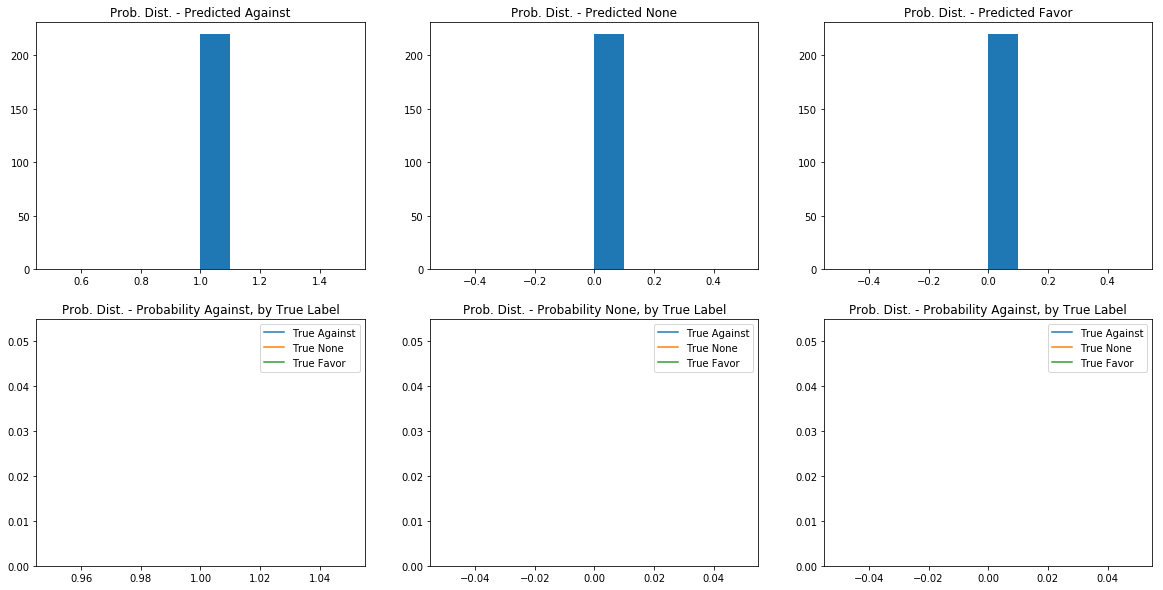

In [23]:
atheism_baseline = baseline_stance(train = twitter_train, 
                                   test = twitter_test, 
                                   topic_in = 'Atheism')
standard_output(model_results = atheism_baseline)

### SVM

In [33]:
def svm_stance(train, test, topic_in):
    # Subset data to topic being tested
    train_topic = train[train['Target'] == topic_in]
    test_topic = test[test['Target'] == topic_in]
    
    #### FEATURES ####
    # Convert training data to sparse matrix 
    # n-gram WORDS
    word_grams = CountVectorizer(ngram_range = (1,3))
    train_nwords = word_grams.fit_transform(train_topic['tweet_clean'])
    test_nwords = word_grams.transform(test_topic['tweet_clean'])
    word_grams_feature_list = word_grams.get_feature_names()
    # n-gram CHARS
    char_grams = CountVectorizer(ngram_range = (2,5), analyzer = 'char')
    train_nchars = char_grams.fit_transform(train_topic['tweet_clean'])
    test_nchars = char_grams.transform(test_topic['tweet_clean'])
    char_grams_feature_list = char_grams.get_feature_names()
    
    # Stack the features
    train_grams = hstack((train_nwords, train_nchars))
    test_grams = hstack((test_nwords, test_nchars))
    full_feature_list = word_grams_feature_list + char_grams_feature_list
       
    #### MODEL ####
    print(topic_in)
    # Train SVM
    start_time_train = time.time()
    svm = SVC(kernel = 'linear', probability = True, class_weight = 'balanced')
    svm.fit(train_grams, train_topic['stance_label'])
    end_time_train = time.time()
#     print("Training time:",end_time_train - start_time_train)

    # Prediction
    start_time_predict = time.time()
    test_predict = svm.predict(test_grams)
    test_predict_proba = svm.predict_proba(test_grams)
    end_time_predict = time.time()
#     print("Prediction time:", end_time_predict - start_time_predict)
    # F1
    f1 = metrics.f1_score(y_true = test_topic['stance_label'], 
                          y_pred = test_predict,
                         average = 'weighted')
    print("F1 Score: " + str(f1))
    
    # Results
    results_dict = {}
    results_dict['model'] = svm
    results_dict['full_feature_list'] = full_feature_list
    results_dict['train_labels'] = train_topic['stance_label']
    results_dict['train_names'] = train_topic['Stance']
    results_dict['test_true_labels'] = test_topic['stance_label']
    results_dict['test_true_names'] = test_topic['Stance']
    results_dict['test_predict'] = test_predict
    results_dict['test_predict_proba'] = test_predict_proba
#     results_dict['test_predict_proba_true'] = [item[test_topic['stance_label'][i]] for i, item in enumerate(test_predict_proba)]
    
    return results_dict

Atheism
F1 Score: 0.7233705781834979
F1 Score: 0.7233705781834979
             precision    recall  f1-score   support

    Against       0.82      0.81      0.82       160
       None       0.46      0.57      0.51        28
      Favor       0.48      0.41      0.44        32

avg / total       0.73      0.72      0.72       220



/home/timspittle/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


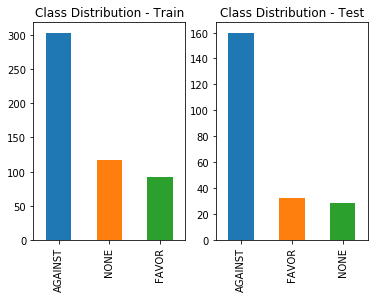

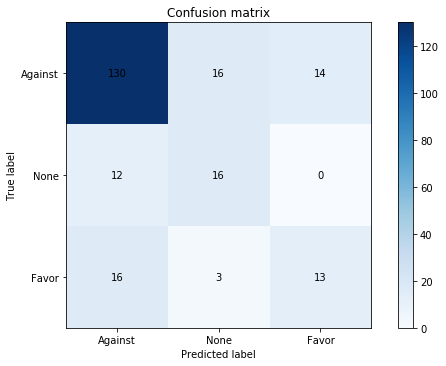

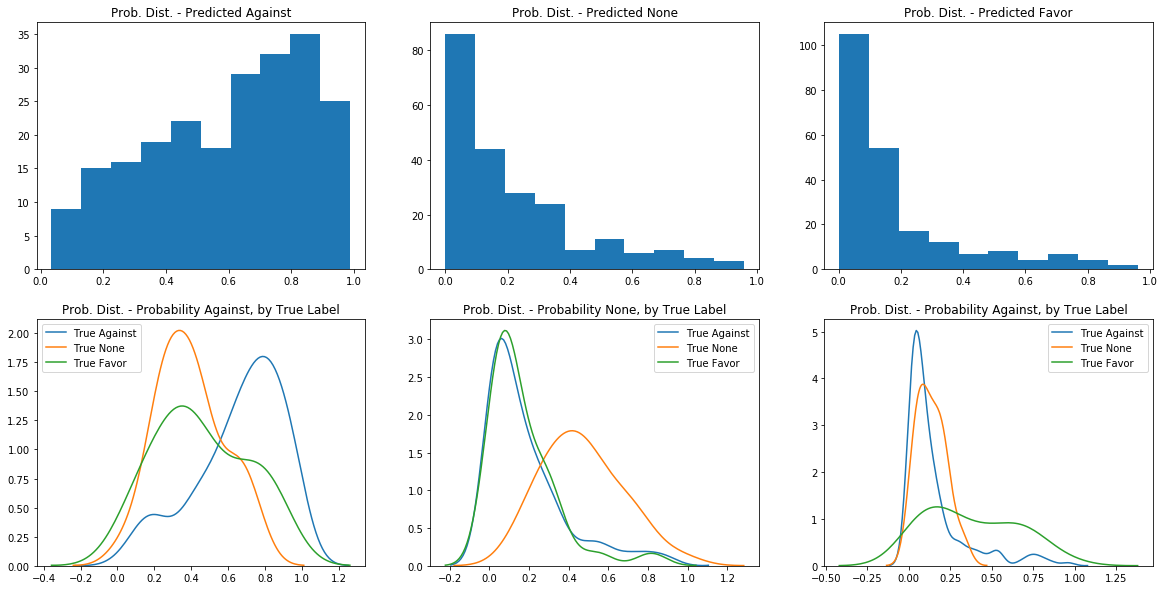

In [32]:
# Atheism
atheism_svm = svm_stance(twitter_train, twitter_test, 'Atheism')
standard_output(model_results = atheism_svm)

In [34]:
# Hillary Clinton
hillary_svm = svm_stance(twitter_train, twitter_test, 'Hillary Clinton')
# Legalization of Abortion
abortion_svm = svm_stance(twitter_train, twitter_test, 'Legalization of Abortion')
# Climate Change is a Real Concern
climatechange_svm = svm_stance(twitter_train, twitter_test, 'Climate Change is a Real Concern')
# Feminist Movement
feminist_svm = svm_stance(twitter_train, twitter_test, 'Feminist Movement')

Hillary Clinton
F1 Score: 0.6900791488873149
Legalization of Abortion
F1 Score: 0.6496491981972541
Climate Change is a Real Concern


/home/timspittle/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 Score: 0.7478246885157096
Feminist Movement
F1 Score: 0.6100954597978991


## Tree

In [38]:
def tree_stance(train, test, topic_in):
    # Subset data to topic being tested
    train_topic = train[train['Target'] == topic_in]
    test_topic = test[test['Target'] == topic_in]
    
    #### FEATURES ####
    # Convert training data to sparse matrix 
    # n-gram WORDS
    word_grams = CountVectorizer(ngram_range = (1,3))
    train_nwords = word_grams.fit_transform(train_topic['tweet_clean'])
    test_nwords = word_grams.transform(test_topic['tweet_clean'])
    word_grams_feature_list = word_grams.get_feature_names()
    # n-gram CHARS
    char_grams = CountVectorizer(ngram_range = (2,5), analyzer = 'char')
    train_nchars = char_grams.fit_transform(train_topic['tweet_clean'])
    test_nchars = char_grams.transform(test_topic['tweet_clean'])
    char_grams_feature_list = char_grams.get_feature_names()
    
    # Stack the features
    train_grams = hstack((train_nwords, train_nchars))
    test_grams = hstack((test_nwords, test_nchars))
    full_feature_list = word_grams_feature_list + char_grams_feature_list
       
    #### MODEL ####
    print(topic_in)
    # Train Tree
    tree = DecisionTreeClassifier()
    tree = tree.fit(train_grams, train_topic['stance_label'])
    
    # Prediction
    test_predict = tree.predict(test_grams)
    test_predict_proba = tree.predict_proba(test_grams)
    
    # F1
    f1 = metrics.f1_score(y_true = test_topic['stance_label'], 
                          y_pred = test_predict,
                         average = 'weighted')
    print("F1 Score: " + str(f1))
    
    # Results
    results_dict = {}
    results_dict['model'] = tree
    results_dict['full_feature_list'] = full_feature_list
    results_dict['train_labels'] = train_topic['stance_label']
    results_dict['train_names'] = train_topic['Stance']
    results_dict['test_true_labels'] = test_topic['stance_label']
    results_dict['test_true_names'] = test_topic['Stance']
    results_dict['test_predict'] = test_predict
    results_dict['test_predict_proba'] = test_predict_proba
    
    return results_dict

Atheism
F1 Score: 0.6306120851888427
F1 Score: 0.6306120851888427
             precision    recall  f1-score   support

    Against       0.82      0.65      0.72       160
       None       0.28      0.57      0.38        28
      Favor       0.36      0.41      0.38        32

avg / total       0.68      0.60      0.63       220



/home/timspittle/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


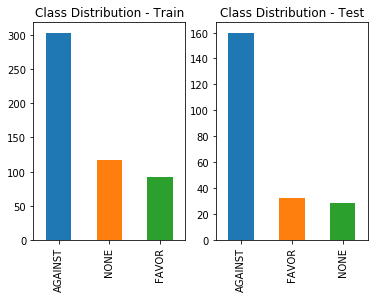

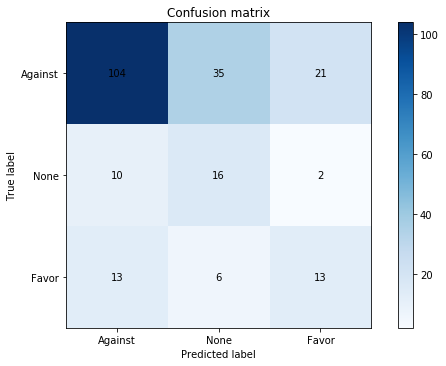

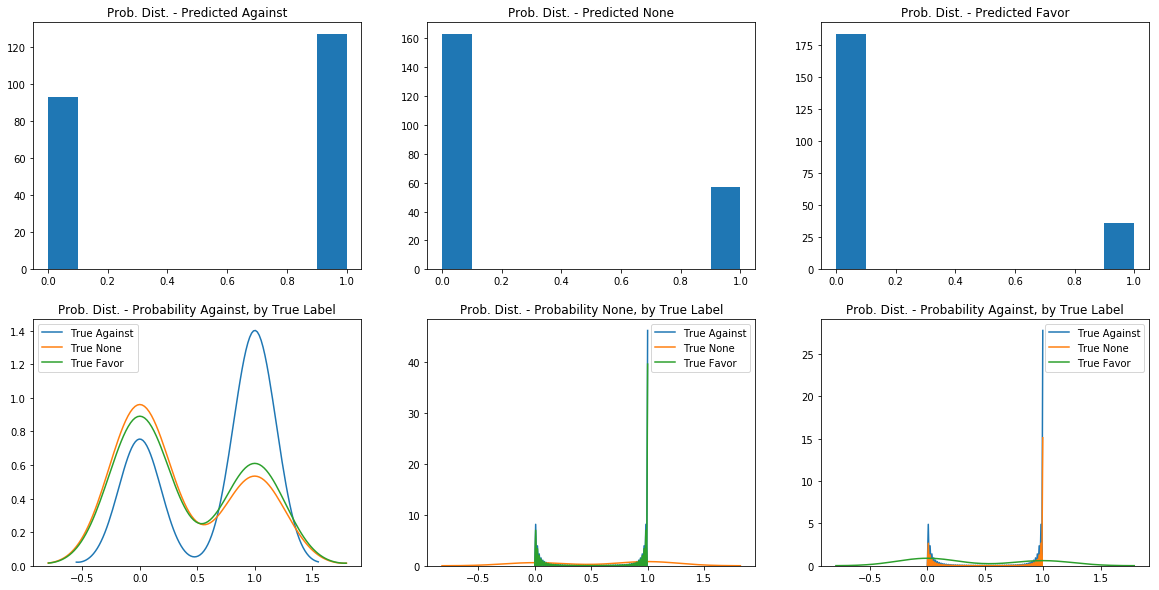

In [39]:
# Atheism
atheism_tree = tree_stance(twitter_train, twitter_test, 'Atheism')
standard_output(model_results = atheism_tree)

## Imbalanced Classes

In [34]:
# Imbalanced classes
from sklearn.utils import resample

# Split out classes
twitter_train_hillary = twitter_train[twitter_train['Target'] == 'Hillary Clinton']
twitter_train_hillary_favor = twitter_train_hillary[twitter_train_hillary['Stance'] == 'FAVOR']
twitter_train_hillary_none = twitter_train_hillary[twitter_train_hillary['Stance'] == 'NONE']
twitter_train_hillary_against = twitter_train_hillary[twitter_train_hillary['Stance'] == 'AGAINST']

twitter_train_hillary_none_upsampled = resample(twitter_train_hillary_none,
                                                replace = True, 
                                                n_samples = twitter_train_hillary_against.shape[0],
                                                random_state = 123)

twitter_train_hillary_favor_upsampled = resample(twitter_train_hillary_favor,
                                                 replace = True, 
                                                 n_samples = twitter_train_hillary_against.shape[0],
                                                 random_state = 123)

twitter_train_hillary_upsampled = pd.concat([twitter_train_hillary_against, 
                                             twitter_train_hillary_none_upsampled,
                                            twitter_train_hillary_favor_upsampled])

# Hillary Clinton (upsampled)
hillary_svm_upsampled = svm_stance(twitter_train_hillary_upsampled, twitter_test, 'Hillary Clinton')
standard_output(model_results = hillary_svm_upsampled)

Against (majority) = (393, 5)
None = (178, 5)
None (upsampled) = (393, 5)
Favor (upsampled) = (118, 5)
Favor (upsampled) = (393, 5)


## Extra - Features

In [317]:
def top_features_by_label(coef_matrix_in, target_names_in, feature_list_in):
    top_index_lists = []
    top_features_lists = []
    
    # Loop through each label in the coefficient matrix and identify the top 5 features
    for loop_labels in range(coef_matrix_in.shape[0]):
        top_5_index = np.argsort(coef_matrix_in[loop_labels])[::-1][:5]
        top_5_features = [feature_list_in[i] for i in top_5_index]

        top_index_lists.append(top_5_index)
        top_features_lists.append(top_5_features)

    # Flatten feature lists 
    full_top_index_list = [item for sublist in top_index_lists for item in sublist]
    full_top_features_list = [item for sublist in top_features_lists for item in sublist]

    # Creat 20x4 labelled table from coefficeint matrix
    top_20_index = pd.DataFrame(data = coef_matrix_in[:,full_top_index_list].transpose(), \
                                columns = target_names_in, index = full_top_features_list)
    # Plot resulting table
    fig, ax = plt.subplots(figsize = (10,10))
    seaborn.heatmap(top_20_index, annot = True)

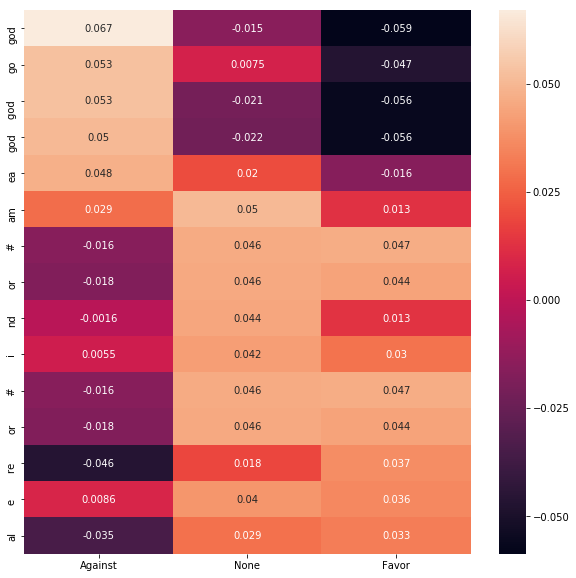

In [318]:
# Top Features
top_features_by_label(coef_matrix_in = atheism_svm['model'].coef_.toarray(), 
                      target_names_in = ['Against', 'None', 'Favor'], 
                      feature_list_in = atheism_svm['full_feature_list'])

In [62]:
# [name for name in atheism_svm['full_feature_list'] if 'god' in name]
# [name for name in atheism_svm['full_feature_list'] if '#' in name]